<h1 align="center">Titanic: Machine Learning from Disaster</h3> 

<img style="float: center;" src="blue-and-white-cruise-ship.png">


---

# Prepare environment

In [1]:
import pandas as pd
import numpy as np
import missingno
import re

import statsmodels.api as sm
from scipy.stats import norm

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import preprocessing
from sklearn import metrics

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings('ignore') 

In [2]:
%matplotlib inline

---

# Overview

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).


## - Data

The data has been split into two groups:

- training set (*train.csv*)
- test set (*test.csv*)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include *gender_submission.csv*, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

## - Dictionary

In [3]:
dataDict = pd.read_csv('data_dictionary.csv')
dataDict

,Variable,Definition,Key
0,survival,Survival,"0 = No, 1 = Yes"
1,pclass,Ticket class,"1 = 1st, 2 = 2nd, 3 = 3rd"
2,sex,Sex,NaN
3,Age,Age in years,NaN
4,sibsp,# of siblings / spouses aboard the Titanic,NaN
5,parch,# of parents / children aboard the Titanic,NaN
6,ticket,Ticket number,NaN
7,fare,Passenger fare,NaN
8,cabin,Cabin number,NaN
9,embarked,Port of Embarkation,"C = Cherbourg, Q = Queenstown, S = Southampton"


## - Notes

- **pclass**: 

A proxy for socio-economic status (SES)

1st = Upper

2nd = Middle

3rd = Lower

- **age**: 

Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

- **sibsp**: 

The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

- **parch**: 

The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.


## - Source

Kaggle: https://www.kaggle.com/c/titanic

---

# Pre-Processing and Exploratory Data Analysis

## - Load data

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
# append dataframes
# train['dataframe'] = 'test'
# test['dataframe'] = 'test'
# test.insert(1, 'Survived', '')
# df = train.append(test).reset_index(drop=True)
# df.info()

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [9]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,418.0,1100.500000,120.810458,892.00,996.2500,1100.5000,1204.75,1309.0000
Pclass,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.00,3.0000
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.00,76.0000
SibSp,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.00,8.0000
Parch,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.00,9.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.50,512.3292


In [10]:
train['Status'] = np.where(train['Survived'] == 1,'Survived', 'Not Survived')
train['Status'].value_counts()

Not Survived    549
Survived        342
Name: Status, dtype: int64

## - Age

Text(0.5, 1.0, 'Passengers and Crew: Age Distribution')

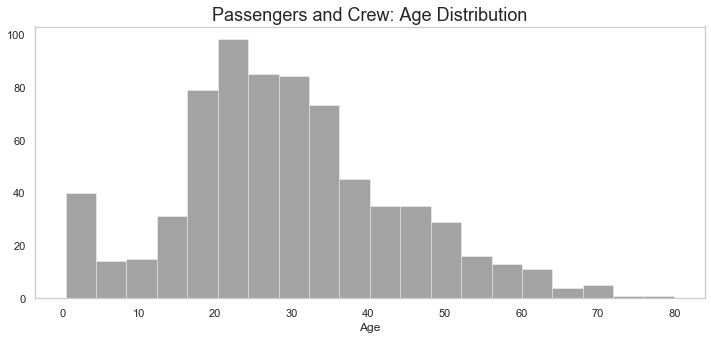

In [11]:
# set figure parameters
sns.set(rc={'figure.figsize':(12, 5)})
sns.set_style("whitegrid", {'axes.grid' : False})


# set data
ageDist = train['Age'].dropna()

# apply plot
sns.distplot(ageDist, 
             kde = False, 
             color = 'k').\
set_title('Passengers and Crew: Age Distribution', size = 18)

In [12]:
bins = [0, 5, 12, 18, 24, 35, 60, np.inf]
ageLabels = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train['Age'], bins, labels = ageLabels).astype(str)

In [13]:
ageTab = pd.crosstab(train['AgeGroup'],train['Status']) #, margins=True, margins_name='Total')
ageTab

Status,Not Survived,Survived
AgeGroup,,
Adult,117,78
Baby,13,31
Child,16,9
Senior,17,5
Student,90,48
Teenager,40,30
Young Adult,131,89
nan,125,52


In [14]:
# reset table index and columns
ageTab = ageTab.stack().reset_index().rename(columns={0:'value'})
ageTab.head(5)

,AgeGroup,Status,value
0,Adult,Not Survived,117
1,Adult,Survived,78
2,Baby,Not Survived,13
3,Baby,Survived,31
4,Child,Not Survived,16


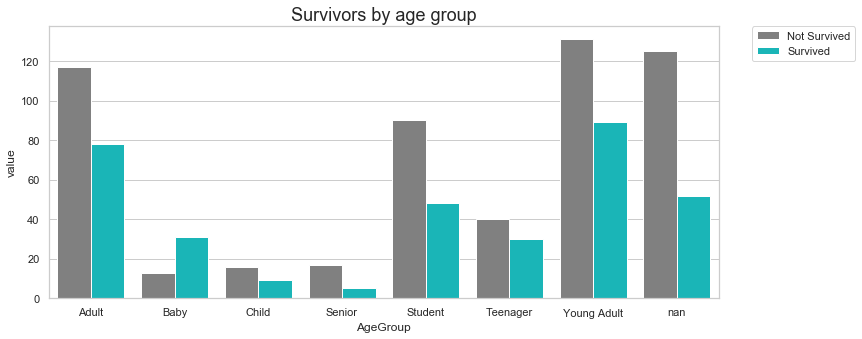

In [15]:
# set figure parameters
sns.set(rc={'figure.figsize':(12, 5)})
sns.set_style('whitegrid')

# set variables to plot
x_tab = ageTab['AgeGroup']
y_tab = ageTab['value']
hue_tab = ageTab['Status']

# apply barplot to dataframe
sns.barplot(x=x_tab, 
            y=y_tab, 
            hue=hue_tab, 
            palette = ['gray','darkturquoise']).\
            set_title('Survivors by age group', size = 18)

# format legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [16]:
# train['AgeGroup'].value_counts()
# sAgeGroup = train[['Status', 'AgeGroup']].groupby(['Status', 'AgeGroup']).agg({'Status': 'count'})


In [17]:
# pd.pivot_table(train,index=["AgeGroup"],
#                values=["Survived"],
#                aggfunc=[np.sum],fill_value=0,margins=True)

## - Sex

In [18]:
sexTab = pd.crosstab(train['Sex'],train['Status'])
sexTab

Status,Not Survived,Survived
Sex,,
female,81,233
male,468,109


Text(0.5, 1.0, 'Passengers and Crew: Age distribution per sex')

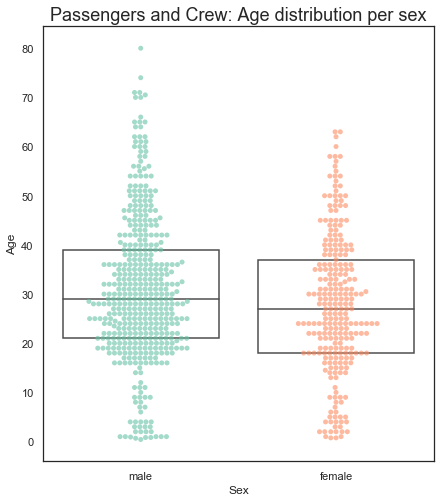

In [19]:
# set figure parameters
sns.set(rc={'figure.figsize':(7, 8)})
sns.set_style('white')

# apply boxplot
sns.boxplot(x="Sex", 
            y="Age", 
            data=train, 
            showcaps=False,
            boxprops={'facecolor':'None'}, 
            showfliers=False,
            whiskerprops={'linewidth':0.})

# apply swatmplot
sns.swarmplot(x="Sex", 
              y="Age", 
              data=train,
              color=".25", 
              alpha=0.6, 
              palette="Set2").\
set_title('Passengers and Crew: Age distribution per sex', size = 18)

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 <a list of 8 Text yticklabel objects>)

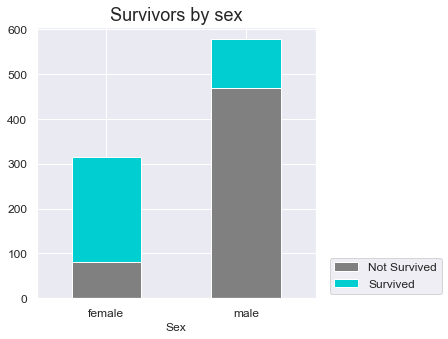

In [20]:
# set figure parameters
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(5, 5)})

# apply stacked barplot to dataframe
sexTab.plot(kind='bar', 
            stacked=True, 
            color = ['gray','darkturquoise']).\
            set_title('Survivors by sex', size = 18)

# format legend
plt.legend(bbox_to_anchor=(1.05, 0.15), loc=2, borderaxespad=0., fontsize = 12)

# format axis
plt.xticks(rotation=0, size = 12)
plt.yticks(size = 12)

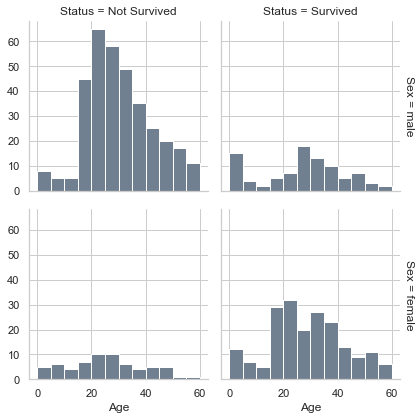

In [21]:
# set figure parameters
sns.set_style('whitegrid')
bins = np.linspace(0, 60, 13)

# apply FacedGrid plot
g = sns.FacetGrid(train, row="Sex", col="Status", margin_titles=True)
g.map(plt.hist, "Age", color = 'slategray', bins=bins)

In [22]:
pd.crosstab(train['AgeGroup'],train['Sex'])

Sex,female,male
AgeGroup,,
Adult,70,125
Baby,21,23
Child,11,14
Senior,3,19
Student,49,89
Teenager,36,34
Young Adult,71,149
nan,53,124


## - Pclass

Text(0.5, 1.0, 'Passengers and Crew: Age distribution per class')

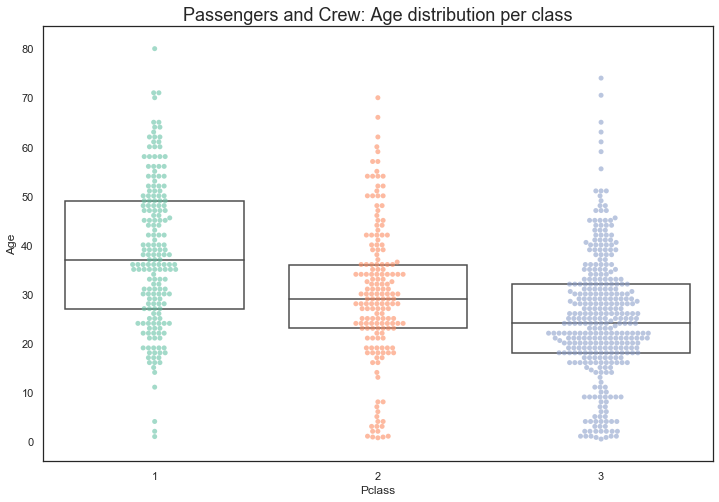

In [23]:
# set figure parameters
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('white')

# apply boxplot
sns.boxplot(x="Pclass", 
            y="Age", 
            data=train, 
            showcaps=False,
            boxprops={'facecolor':'None'}, 
            showfliers=False,
            whiskerprops={'linewidth':0.})

# apply swatmplot
sns.swarmplot(x="Pclass", 
              y="Age", 
              data=train,
              color=".25", 
              alpha=0.6, 
              palette="Set2").\
set_title('Passengers and Crew: Age distribution per class', size = 18)

In [24]:
classTab = pd.crosstab(train['Pclass'],train['Status'])
classTab

Status,Not Survived,Survived
Pclass,,
1,80,136
2,97,87
3,372,119


(array([  0., 100., 200., 300., 400., 500., 600.]),
 <a list of 7 Text yticklabel objects>)

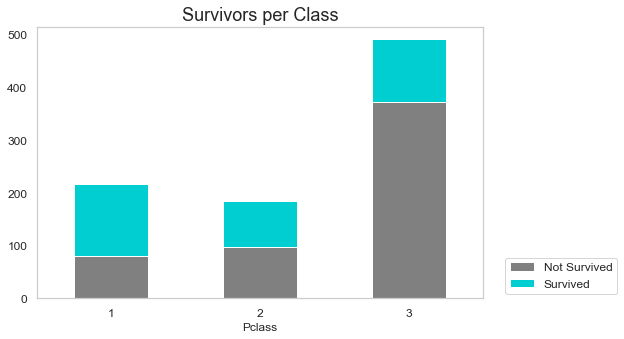

In [25]:
# set figure parameters
sns.set(rc={'figure.figsize':(8, 5)})
sns.set_style("whitegrid", {'axes.grid' : False})

# apply stacked barplot to dataframe
classTab.plot(kind='bar', stacked=True, color = ['gray','darkturquoise']).set_title('Survivors per Class', size = 18)

# format legend
plt.legend(bbox_to_anchor=(1.05, 0.15), loc=2, borderaxespad=0., fontsize = 12)

# format axis
plt.xticks(rotation=0, size = 12)
plt.yticks(size = 12)

## - Name

In [26]:
# create column with title segmentation
train['Title'] = train['Name'].str.extract('([A-Za-z]+)\.', expand=False)

In [27]:
titleTab = pd.crosstab(train['Title'],train['Status'])
titleTab

Status,Not Survived,Survived
Title,,
Capt,1,0
Col,1,1
Countess,0,1
Don,1,0
Dr,4,3
Jonkheer,1,0
Lady,0,1
Major,1,1
Master,17,23


In [28]:
titleTab = train[['Title','Age']].groupby('Title').agg({'Age': ['count']}).reset_index().rename(columns={0:'value'})
titleTab

,Title,Age
,,count
0,Capt,1
1,Col,2
2,Countess,1
3,Don,1
4,Dr,6
5,Jonkheer,1
6,Lady,1
7,Major,2
8,Master,36


In [29]:
# create dictionary with title segmentation
titleDic = {'Rare': ['Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'],
            'Royal': ['Countess', 'Lady', 'Sir'],
            'Miss': ['Mlle', 'Ms', 'Miss'],
            'Mr': ['Mr'], 
            'Master': ['Master'], 
            'Mrs':['Mme', 'Mrs']}

In [30]:
# reverse key-value from dictionary
d = {k: oldk for oldk, oldv in titleDic.items() for k in oldv}
d

{'Capt': 'Rare',
 'Col': 'Rare',
 'Don': 'Rare',
 'Dr': 'Rare',
 'Major': 'Rare',
 'Rev': 'Rare',
 'Jonkheer': 'Rare',
 'Dona': 'Rare',
 'Countess': 'Royal',
 'Lady': 'Royal',
 'Sir': 'Royal',
 'Mlle': 'Miss',
 'Ms': 'Miss',
 'Miss': 'Miss',
 'Mr': 'Mr',
 'Master': 'Master',
 'Mme': 'Mrs',
 'Mrs': 'Mrs'}

In [31]:
# create column with summarized title segmentation
train['Title'] = train['Title'].map(d)

In [32]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare', 'Royal'], dtype=object)

In [33]:
title_Tab = train[['Title','Age']].groupby('Title').agg({'Age': ['count', 'mean', 'min', 'max']})
title_Tab

Age                        
       count       mean    min   max
Title                               
Master    36   4.574167   0.42  12.0
Miss     149  21.845638   0.75  63.0
Mr       398  32.368090  11.00  80.0
Mrs      109  35.788991  14.00  63.0
Rare      19  45.894737  23.00  70.0
Royal      3  43.333333  33.00  49.0

In [34]:
# define data to plot
titleTab = pd.crosstab(train['Title'],train['Status']).reset_index().rename(columns={0:'value'})
titleTab

Status,Title,Not Survived,Survived
0,Master,17,23
1,Miss,55,130
2,Mr,436,81
3,Mrs,26,100
4,Rare,15,5
5,Royal,0,3


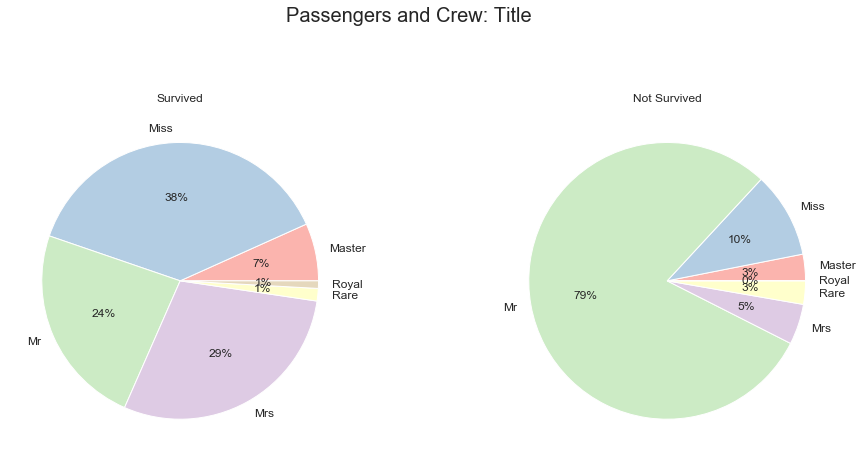

In [35]:
# define source lables and counts
survived_labels = titleTab['Title']
survived_counts = titleTab['Survived']
not_survived_labels = titleTab['Title']
not_survived_counts = titleTab['Not Survived']

# set figure parameters
plt.figure(1, figsize=(16,14))
the_grid = GridSpec(2, 2)
cmap = plt.get_cmap('Pastel1')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]

# apply pie plot

plt.subplot(the_grid[0, 0], aspect=1, title='Survived')
plt.pie(survived_counts,
        labels = survived_labels, 
        autopct ='%.0f%%', 
        textprops = {'fontsize': 12}, 
        shadow = False, 
        colors = colors)

plt.subplot(the_grid[0, 1], aspect=1, title='Not Survived')
plt.pie(not_survived_counts,
        labels = not_survived_labels, 
        autopct = '%.0f%%', 
        textprops={'fontsize': 12}, 
        shadow=False, 
        colors = colors)

# set title parameters
plt.suptitle('Passengers and Crew: Title', fontsize=20)
mpl.rc('axes', labelsize=16, titlesize=18)

In [36]:
# extract the last name
train['lastName'] = train['Name'].str.rsplit(',').str[0]
train['NameLength'] = train['lastName'].str.len()

In [37]:
# largest last name
train[['lastName', 'NameLength']].nlargest(10,['NameLength'])

,lastName,NameLength
430,Bjornstrom-Steffansson,22
444,Johannesen-Bratthammer,22
307,Penasco y Castellana,20
505,Penasco y Castellana,20
351,Williams-Lambert,16
587,Frolicher-Stehli,16
632,Stahelin-Maeglin,16
192,Andersen-Jensen,15
647,Simonius-Blumer,15
873,Vander Cruyssen,15


In [38]:
# smallest last name
train[['lastName', 'NameLength']].nsmallest(10,['NameLength'])

,lastName,NameLength
66,Nye,3
152,Meo,3
210,Ali,3
344,Fox,3
462,Gee,3
643,Foo,3
646,Cor,3
692,Lam,3
784,Ali,3
815,Fry,3


In [39]:
# count the number of people with the same last name
nameFamimly = train[['lastName','NameLength']].groupby('lastName').count().reset_index()
nameFamimly = nameFamimly[['lastName', 'NameLength']].nlargest(50,['NameLength'])
nameFamimly = nameFamimly.rename(columns={'lastName': 'Famimly Name', 'NameLength': 'Count Family Name'}, errors="raise")
nameFamimly.head(10)

,Famimly Name,Count Family Name
16,Andersson,9
532,Sage,7
100,Carter,6
220,Goodwin,6
292,Johnson,6
464,Panula,6
563,Skoog,6
505,Rice,5
25,Asplund,4
32,Baclini,4


In [40]:
# turn data into a dictionary
nameDict = dict(zip(nameFamimly['Famimly Name'], nameFamimly['Count Family Name']))
text = " ".join([(k + " ")*v for k,v in nameDict.items()])

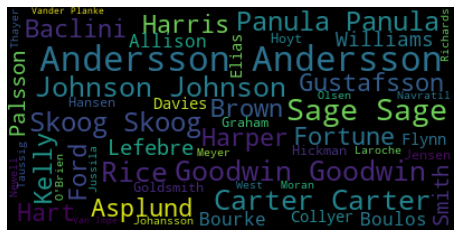

In [41]:
# plot word cloud
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
wordcloud = WordCloud(max_font_size=40).generate(text)

In [42]:
# reset the name length to the full name
train['NameLength'] = train['Name'].str.len()

In [43]:
bins = [0,25, 40, np.inf]
ageLabels = ['small', 'medium', 'large',]
train["NameLength"] = pd.cut(train["NameLength"], bins, labels = ageLabels)
train['NameLength'].value_counts()

small     458
medium    343
large      90
Name: NameLength, dtype: int64

## - Fare

Text(0.5, 1.0, 'Fare - Before data treatment')

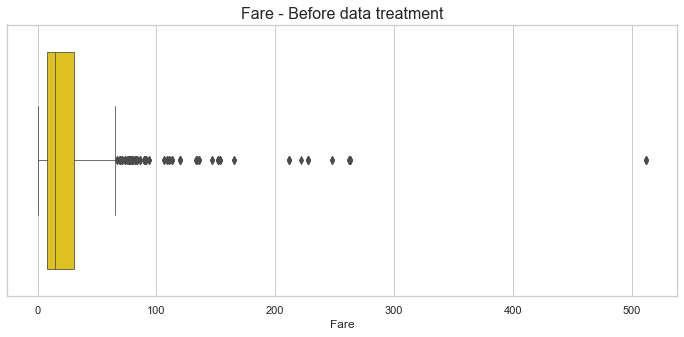

In [44]:
# set plot figure parameters
sns.set(rc={'figure.figsize':(12, 5)})
sns.set_style('whitegrid')

# apply bloxplot
sns.boxplot(y = train["Fare"], 
            orient = 'h', 
            color = 'gold', 
            linewidth = 0.8).set_title('Fare - Before data treatment', size = 16)

In [45]:
bins = [0, 5, 50, 75, 100, 150, 200, np.inf]
fareLabels = ['Very Cheap', 'Cheap', 'Fare', 'Reasonable', 'Expensive', 'Very Expensive', 'Super Expensive']
train['FareBandwidth'] = pd.cut(train['Fare'], bins, labels = fareLabels).astype(str)
train['FareBandwidth'].value_counts()

Cheap              714
Fare                63
Reasonable          44
Expensive           24
Super Expensive     20
nan                 15
Very Expensive       9
Very Cheap           2
Name: FareBandwidth, dtype: int64

## - Family

In [46]:
train["FamilySize"] = train['SibSp']+train['Parch'] + 1

In [47]:
train['Single'] = train['FamilySize'].map(lambda s: 1 if s == 1 else 0)
train['SmallFam'] = train['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
train['MedFam'] = train['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
train['LargeFam'] = train['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

In [48]:
famTab = pd.crosstab(train['FamilySize'], train['Status'])
famTab

Status,Not Survived,Survived
FamilySize,,
1,374,163
2,72,89
3,43,59
4,8,21
5,12,3
6,19,3
7,8,4
8,6,0
11,7,0


## - Embarqued

In [49]:
embTab = pd.crosstab(train['Embarked'], train['Status'])
embTab

Status,Not Survived,Survived
Embarked,,
C,75,93
Q,47,30
S,427,217


---

# Outliers

## - Fare

In [50]:
q1 = train["Fare"].quantile(0.25)
q3 = train["Fare"].quantile(0.75)
iqr = q3 - q1                 

In [51]:
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

In [52]:
train['Fare'].sort_values(ascending=False).head(10)

679    512.3292
258    512.3292
737    512.3292
341    263.0000
438    263.0000
88     263.0000
27     263.0000
311    262.3750
742    262.3750
299    247.5208
Name: Fare, dtype: float64

In [53]:
train['Fare'] = np.where(train['Fare'] > 500, 263, train['Fare'])

In [54]:
train['Fare'].sort_values(ascending=False).head(10)

341    263.0000
438    263.0000
88     263.0000
679    263.0000
258    263.0000
737    263.0000
27     263.0000
311    262.3750
742    262.3750
299    247.5208
Name: Fare, dtype: float64

Text(0.5, 1.0, 'Fare Distribution - After Treatment')

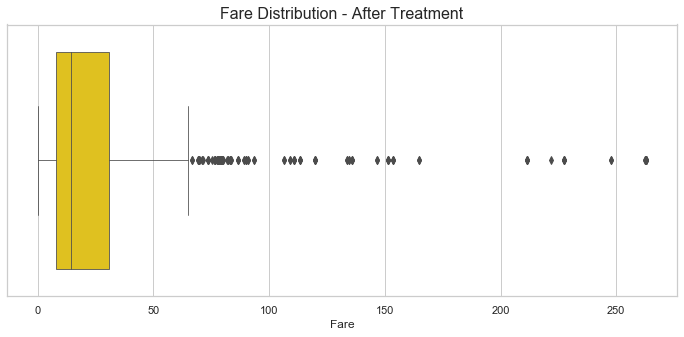

In [55]:
# set plot figure parameters
sns.set(rc={'figure.figsize':(12, 5)})
sns.set_style('whitegrid')

# apply boxplot
sns.boxplot(y = train["Fare"], 
            orient = 'h', 
            color = 'gold', 
            linewidth = 0.8).set_title('Fare Distribution - After Treatment', size = 16)

---

# Missing Values

## Missing values: train dataset

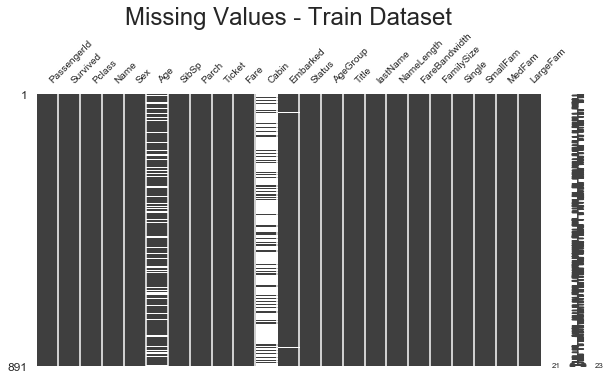

In [56]:
missingno.matrix(train, figsize = (10,5), fontsize = 10)
plt.title("Missing Values - Train Dataset", fontsize = 24)
plt.show()

In [57]:
train.isnull().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age              177
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            687
Embarked           2
Status             0
AgeGroup           0
Title              0
lastName           0
NameLength         0
FareBandwidth      0
FamilySize         0
Single             0
SmallFam           0
MedFam             0
LargeFam           0
dtype: int64

## - Age

In [58]:
train[['Title','Age']].groupby('Title').agg({'Age': ['count', 'mean', 'max', 'min']})

Age                        
       count       mean   max    min
Title                               
Master    36   4.574167  12.0   0.42
Miss     149  21.845638  63.0   0.75
Mr       398  32.368090  80.0  11.00
Mrs      109  35.788991  63.0  14.00
Rare      19  45.894737  70.0  23.00
Royal      3  43.333333  49.0  33.00

In [59]:
titleDic = {'Master': 5, 'Miss': 22, 'Mr': 33, 'Mrs': 36, 'Rare': 46, 'Royal': 44}

In [60]:
train['Age'] = train['Age'].fillna(train['Title'].map(titleDic))
# train['Age'] = np.where(train['Age'].isnull(), train['Title'].apply(lambda x: titleDic[x]), train['Age'])

In [61]:
train[['Title','Age']].groupby('Title').agg({'Age': ['count', 'mean', 'max', 'min']})

Age                        
       count       mean   max    min
Title                               
Master    40   4.616750  12.0   0.42
Miss     185  21.875676  63.0   0.75
Mr       517  32.513540  80.0  11.00
Mrs      126  35.817460  63.0  14.00
Rare      20  45.900000  70.0  23.00
Royal      3  43.333333  49.0  33.00

## - Embarked

In [62]:
train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [63]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [64]:
train['Embarked'] = train['Embarked'].fillna('S')

In [65]:
train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

## - Check missing values on train dataset

In [66]:
train.isnull().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            687
Embarked           0
Status             0
AgeGroup           0
Title              0
lastName           0
NameLength         0
FareBandwidth      0
FamilySize         0
Single             0
SmallFam           0
MedFam             0
LargeFam           0
dtype: int64

## Missing values: test dataset

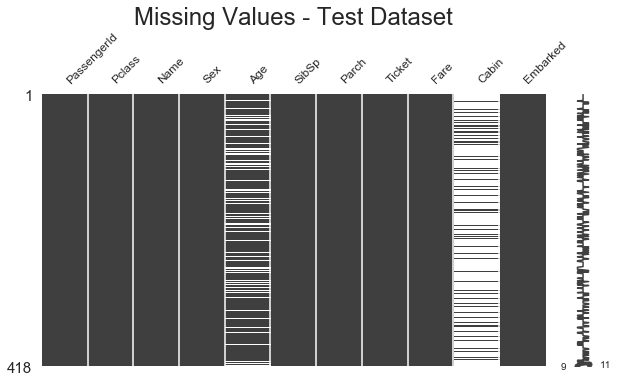

In [67]:
missingno.matrix(test, figsize = (10,5), fontsize = 12)
plt.title("Missing Values - Test Dataset",  fontsize = 24)
plt.show()

In [68]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## - Age

In [69]:
test['Title'] = test['Name'].str.extract('([A-Za-z]+)\.', expand=False)

test['Title'] = test['Title'].replace([ 'Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
test['Title'] = test['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
test['Title'] = test['Title'].replace(['Mlle', 'Ms'], 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')

test[['Title','Age']].groupby('Title').agg({'Age': ['count', 'mean', 'max', 'min']})

Age                        
       count       mean   max    min
Title                               
Master    17   7.406471  14.5   0.33
Miss      64  21.774844  45.0   0.17
Mr       183  32.000000  67.0  14.00
Mrs       62  38.903226  76.0  16.00
Rare       6  43.833333  53.0  30.00

In [70]:
test[['Title','Age']].groupby('Title').agg({'Age': ['count', 'mean', 'max', 'min']})
titleDic = {'Master': 5, 'Miss': 22, 'Mr': 33, 'Mrs': 36, 'Rare': 46, 'Royal': 44}
test['Age'] = test['Age'].fillna(test['Title'].map(titleDic))

In [71]:
test[['Title','Age']].groupby('Title').agg({'Age': ['count', 'mean', 'max', 'min']})

Age                        
       count       mean   max    min
Title                               
Master    21   6.948095  14.5   0.33
Miss      79  21.817595  45.0   0.17
Mr       240  32.237500  67.0  14.00
Mrs       72  38.500000  76.0  16.00
Rare       6  43.833333  53.0  30.00

## - Fare

In [72]:
test[['Pclass','Fare']].groupby('Pclass').agg({'Fare': ['count', 'mean', 'max', 'min']})

Fare                             
       count       mean       max     min
Pclass                                   
1        107  94.280297  512.3292  0.0000
2         93  22.202104   73.5000  9.6875
3        217  12.459678   69.5500  3.1708

In [73]:
test["Fare"] = test["Fare"].fillna(12)

## - Check missing values on test dataset

In [74]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Title            0
dtype: int64

---

# Feature Engineering

In [75]:
lbe = preprocessing.LabelEncoder()

## Integer Encoding

*train dataset*

In [76]:
train['Embarked'] = lbe.fit_transform(train['Embarked'])

In [77]:
train['Sex'] = lbe.fit_transform(train['Sex'])

In [78]:
train['Title'] = lbe.fit_transform(train['Title'])

In [79]:
train['AgeGroup'] = lbe.fit_transform(train['AgeGroup'])

In [80]:
train['Sex'] = lbe.fit_transform(train['Sex'])

In [81]:
train['FareBandwidth'] = lbe.fit_transform(train['FareBandwidth'])

In [82]:
train['Single'] = train['FamilySize'].map(lambda s: 1 if s == 1 else 0)
train['SmallFam'] = train['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
train['MedFam'] = train['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
train['LargeFam'] = train['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

*test dataset*

In [83]:
test['Embarked'] = lbe.fit_transform(test['Embarked'])

In [84]:
test['Sex'] = lbe.fit_transform(test['Sex'])

In [85]:
test['Title'] = lbe.fit_transform(test['Title'])

In [86]:
bins = [0, 5, 12, 18, 24, 35, 60, np.inf]
ageLabels = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
test['AgeGroup'] = pd.cut(test['Age'], bins, labels = ageLabels).astype(str)
test['AgeGroup'] = lbe.fit_transform(test['AgeGroup'])

In [87]:
test['Sex'] = lbe.fit_transform(test['Sex'])

In [88]:
bins = [0, 5, 50, 75, 100, 150, 200, np.inf]
fareLabels = ['Very Cheap', 'Cheap', 'Fare', 'Reasonable', 'Expensive', 'Very Expensive', 'Super Expensive']
test['FareBandwidth'] = pd.cut(train['Fare'], bins, labels = fareLabels).astype(str)
test['FareBandwidth'].value_counts()
test['FareBandwidth'] = lbe.fit_transform(test['FareBandwidth'])

In [89]:
test["FamilySize"] = train["SibSp"]+train["Parch"]+1
test['Single'] = test['FamilySize'].map(lambda s: 1 if s == 1 else 0)
test['SmallFam'] = test['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
test['MedFam'] = test['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
test['LargeFam'] = test['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

## One-hot encoding

*train dataset*

In [90]:
train = pd.get_dummies(train, columns = ['Title'])

In [91]:
train = pd.get_dummies(train, columns = ['Embarked'], prefix='Embark')

In [92]:
train['Pclass'] = train['Pclass'].astype('category')

In [93]:
train = pd.get_dummies(train, columns = ['Pclass'],prefix='Pclass')

*test dataset*

In [94]:
test = pd.get_dummies(test, columns = ['Title'])

In [95]:
test = pd.get_dummies(test, columns = ['Embarked'], prefix='Embark')

In [96]:
test["Pclass"] = test['Pclass'].astype('category')

In [97]:
test = pd.get_dummies(test, columns = ['Pclass'],prefix='Pclass')

---

# Modeling: Logistic Regression

## - Correlation analysis and feature selection

In [98]:
train.head(3).T

,0,1,2
PassengerId,1,2,3
Survived,0,1,1
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina"
Sex,1,0,0
Age,22,38,26
SibSp,1,1,0
Parch,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282
Fare,7.25,71.2833,7.925
Cabin,NaN,C85,NaN


In [99]:
x_cols = [
'Sex',
'Age',
'Fare',
'Single',
'SmallFam',
'MedFam',
'LargeFam',
'Title_0',
'Title_1',
'Title_2',
'Title_3',
'Title_4',
'Title_5',
'Embark_0',
'Embark_1',
'Embark_2',
'Pclass_1',
'Pclass_2',
'Pclass_3']

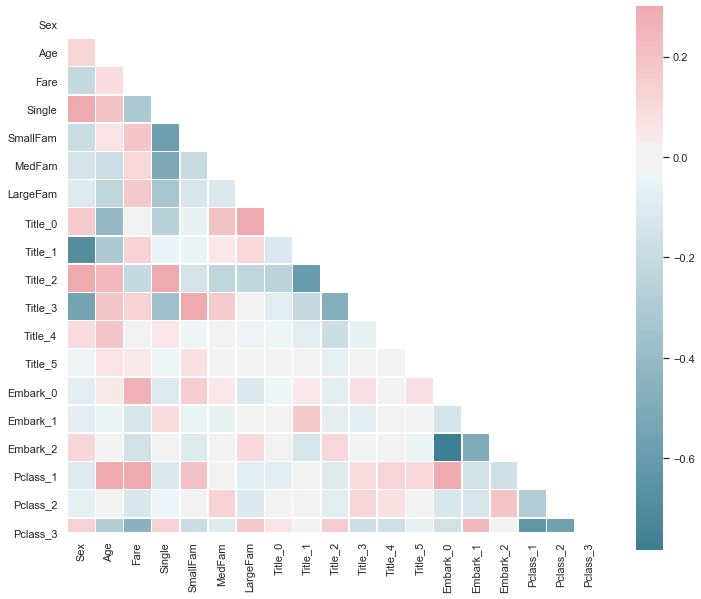

In [100]:
# compute correlation
corr = train[x_cols].corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 20))

# apply heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5})

In [101]:
# define dependent and independent variables
X = train[x_cols].astype(int) 
y = train['Survived']

In [102]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

         Current function value: 0.398479
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      875
Method:                           MLE   Df Model:                           15
Date:                Tue, 09 Jun 2020   Pseudo R-squ.:                  0.4016
Time:                        09:47:14   Log-Likelihood:                -355.04
converged:                      False   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 5.083e-92
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Sex          -14.1913    693.431     -0.020      0.984   -1373.292    1344.909
Age           -0.0264      0.010     -2.693      0.007      -0.04

## - Model Fitting

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [104]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test dataset: {:.4f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test dataset: 0.8134


---

# Model evaluation

## - Confusion Matrix

In [106]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[137  17]
 [ 33  81]]


In [107]:
print("True Positives: %d" %(confusion_matrix[0, 0]))
print("True Negatives: %d" %(confusion_matrix[1, 1]))
print("False Positives or Type 1 Error: %d" %(confusion_matrix[0, 1]))
print("False Negatives or Type 2 Error: %d" %(confusion_matrix[1, 0]))

True Positives: 137
True Negatives: 81
False Positives or Type 1 Error: 17
False Negatives or Type 2 Error: 33


## - Precision, Recall and F-measure

In [108]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       154
           1       0.83      0.71      0.76       114

    accuracy                           0.81       268
   macro avg       0.82      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268



## - ROC Curve

In [109]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

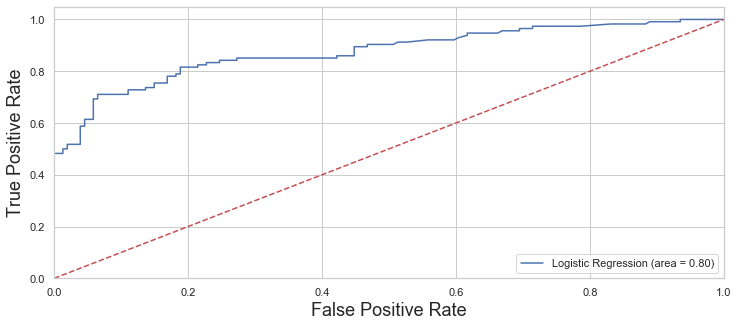

In [110]:
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
# plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

---

# Model Application

## - Data Pre-processing [test]

In [111]:
test.head(3).T

,0,1,2
PassengerId,892,893,894
Name,"Kelly, Mr. James","Wilkes, Mrs. James (Ellen Needs)","Myles, Mr. Thomas Francis"
Sex,1,0,1
Age,34.5,47,62
SibSp,0,1,0
Parch,0,0,0
Ticket,330911,363272,240276
Fare,7.8292,7,9.6875
Cabin,NaN,NaN,NaN
AgeGroup,6,0,3


In [112]:
test['Title_5'] = 0

In [113]:
x_cols = [
'Sex',
'Age',
'Fare',
'Single',
'SmallFam',
'MedFam',
'LargeFam',
'Title_0',
'Title_1',
'Title_2',
'Title_3',
'Title_4',
'Title_5',
'Embark_0',
'Embark_1',
'Embark_2',
'Pclass_1',
'Pclass_2',
'Pclass_3']

## - Apply logistic regression model

In [114]:
X_test = test[x_cols].astype(int)

In [115]:
y_pred = logreg.predict(X_test)

In [116]:
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## - Save model output

In [117]:
data = {'PassengerId': X_test.index, 'Survived':y_pred}

In [118]:
df = pd.DataFrame (data, columns = ['PassengerId','Survived'])
# df.set_index('PassengerId', inplace=True)

In [119]:
df.head()

,PassengerId,Survived
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1


In [120]:
df.to_csv(r'gender_submission.csv', index = False)